In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy.stats as stats
import math as math

pd.options.mode.chained_assignment = None

In [4]:
file_names = ['..\\PhD_data\\BH06\\BH06_raw_baseline.xlsx']

group_names = {0:'lOFC',
               1:'PrL'} 

lOFC = [1,2,3,4,5,6,8,9,11,12,13,14,15,16,24,25,26,32]

PrL = [18,19,20,21,22,23,27,28,29,30,31]

groups = [lOFC, PrL]

startsess = 1
endsess = 6
title = 'Baseline performance'



In [15]:
def load_data(fnames, reset_sessions = False): 
#load data from computer
    for i,file in enumerate(fnames):
        if i == 0:
            df = pd.read_excel(fnames[i])
            if reset_sessions:
                for i,session in enumerate(df.Session.unique()):
                    for j in range(len(df)):
                        if df.at[j,'Session'] == session:
                            df.at[j,'Session'] = i + 1
        else:
            df2 = pd.read_excel(fnames[i])
            if reset_sessions:
                for i,session in enumerate(df2.Session.unique()):
                    for j in range(len(df2)):
                        if df2.at[j,'Session'] == session:
                            df2.at[j,'Session'] = i + 1
            df = df.append(df2, ignore_index = True)
    return df

def check_sess(df):
    pd.set_option('display.max_rows', None)
    print(df.groupby(['Subject','Session'])['Trial'].max())
    pd.set_option('display.max_rows',df.Subject.max())
    
def get_choices(df):
    #set up option column with correct P1 to P4 configuration for version A and B
    configA = np.array([1, 4, 0, 2, 3])
    configB = np.array([4, 1, 0, 3, 2])

    df['option'] = df['MSN'].str.contains("B").values*configB[df['Chosen'].astype('int').ravel()-1].astype('int') + \
        df['MSN'].str.contains("A").values*configA[df['Chosen'].astype('int').ravel()-1].astype('int')

    #fix zeros
    for i in range(len(df)):
        if df['Chosen'][i] == 0:
            df['option'][i] = 0
    return df

def remove_subject(df, subs):
    for sub in subs:
        df.drop(list(df.loc[df['Subject']==sub].index), inplace=True)
    df.reset_index(inplace=True)
    return df

def edit_sess(df, orig_sess, new_sess,subs = 'all'):
    if subs == 'all':
        for i,sess in enumerate(orig_sess):
            for i in range(len(df)):
                if df.at[i,'Session']== sess:
                    df.at[i,'Session'] = new_sess[i]
    else:
        for sub in subs:
            index = list(df.loc[df['Subject']==sub].index)
            for i,sess in enumerate(orig_sess):
                for idx in index:
                    if df.at[idx,'Session'] == sess:
                        df.at[idx,'Session'] = new_sess[i]
    return df
    
    

def get_sum_choice(num, df, mode):
    #get choice information for given group number or session number
    df1 = df.loc[df[mode] == num]
    subs = df1.Subject.unique()
    subs.sort()
    percentage = pd.DataFrame(columns=[str(num) + 'P1',str(num) + 'P2',str(num) + 'P3',str(num) + 'P4'])
    for sub in subs:
        for i,column in enumerate(percentage.columns):
            percentage.at[sub,column] = (len(df1.loc[(df1.option == i + 1) & 
                                            (df1.Subject == sub)]))/(len(df1.loc[(df1['option'] != 0) & 
                                                                                (df.Subject == sub)])) *100
    return percentage

def get_sum_choice_all(df, mode):
    df_sess = []
    for num in np.sort(df[mode].unique()):
        df_sess.append(get_sum_choice(num,df,mode))
    df1 = pd.concat(df_sess, axis=1)
    for num in np.sort(df[mode].unique()):
        df1['risk'+ str(num)] = df1[str(num)+'P1'] + df1[str(num)+'P2']- df1[str(num)+'P3'] - df1[str(num)+'P4']
    return df1

def get_premature(df_raw,df_sum,mode):
    #extract premature response information on either group or session
    prem_resp = df_raw.groupby(['Subject', mode],as_index=False)['Premature_Resp'].sum()

    prem_resp['Trials'] = df_raw.groupby(['Subject',mode],as_index=False)['Trial'].count()['Trial']

    prem_resp['prem_percent'] = prem_resp['Premature_Resp']/prem_resp['Trials'] * 100

    for num in np.sort(df_raw[mode].unique()):
        df_sum['prem' + str(num)] = prem_resp.loc[prem_resp[mode]==num].set_index('Subject')['prem_percent']
    return df_sum
    
    
def get_latencies(df_raw,df_sum,mode):
    #extract collect and choice lat information
    df_raw = df_raw.loc[df_raw['Chosen'] != 0]
    collect_lat = df_raw.groupby(['Subject',mode],as_index=False)['Collect_Lat'].mean()
    choice_lat = df_raw.groupby(['Subject',mode],as_index=False)['Choice_Lat'].mean()
    for num in np.sort(df_raw[mode].unique()):
        df_sum['collect_lat' + str(num)] = collect_lat.loc[collect_lat[mode]==num].set_index('Subject')['Collect_Lat']
    for num in np.sort(df_raw[mode].unique()):
        df_sum['choice_lat' + str(num)] = choice_lat.loc[choice_lat[mode]==num].set_index('Subject')['Choice_Lat']
    return df_sum


def get_omit(df_raw,df_sum,mode):
    omit = df_raw.groupby(['Subject',mode],as_index=False)['Omit'].sum()
    for num in np.sort(df_raw[mode].unique()):
        df_sum['omit' + str(num)] = omit.loc[omit[mode]==num].set_index('Subject')['Omit']
    return df_sum

def get_trials(df_raw,df_sum,mode):
    trials = df_raw.groupby(['Subject',mode],as_index=False)['Trial'].max()
    for num in np.sort(df_raw[mode].unique()):
        df_sum['trial' + str(num)] = trials.loc[trials[mode]==num].set_index('Subject')['Trial']
    return df_sum

def get_trials_init(df_raw,df_sum,mode):
    trials = df_raw.groupby(['Subject',mode],as_index=False)['Trial'].count()
    for num in np.sort(df_raw[mode].unique()):
        df_sum['trial_init' + str(num)] = trials.loc[trials[mode]==num].set_index('Subject')['Trial']
    return df_sum

def get_summary_data(df_raw, mode='Session'):
    df_raw = get_choices(df_raw)
    df_sum = get_sum_choice_all(df_raw,mode)
    df_sum = get_latencies(df_raw,df_sum,mode)
    df_sum = get_omit(df_raw,df_sum,mode)
    df_sum = get_trials(df_raw,df_sum,mode)
    df_sum = get_premature(df_raw,df_sum,mode)
    return df_sum
    
def get_group_means_sem(df_sum,groups, group_names):
    dfs = []
    for group in groups:
        dfs.append(df_sum.loc[group])
    avg_scores = pd.DataFrame(columns=list(df_sum.columns))
    avg_stderror = pd.DataFrame(columns=avg_scores.columns)
    for column in avg_scores.columns:
        for i in range(len(groups)):
            avg_scores.at[i,column] = dfs[i][column].mean()
            avg_stderror.at[i,column] = stats.sem(dfs[i][column])
            
    avg_scores.rename(index=group_names,inplace = True)
    avg_stderror.rename(index=group_names, inplace = True)
    return avg_scores, avg_stderror

def get_risk_status(df1, startsess, endsess):
    #get risk status from specified sessions
    #create lists for indexing based on risk score
    risky = []
    optimal = []
    startsess = 'risk' + str(startsess)
    endsess = 'risk' + str(endsess)
    df1['mean_risk'] = df1.loc[:,startsess:endsess].mean(axis=1)
    for sub in df1.index:
        if df1.at[sub,'mean_risk'] > 0:
            df1.at[sub,'risk_status'] = 1
            optimal.append(sub)
        elif df1.at[sub,'mean_risk'] < 0:
            df1.at[sub,'risk_status'] = 2
            risky.append(sub)
    return df1, risky, optimal

def choice_bar_plot(startsess, endsess, scores, sem, groups = None):
    sess = list(range(startsess,endsess + 1))
    labels = ['P1','P2','P3','P4']
    df = pd.DataFrame()
    df1 = pd.DataFrame()
    for choice in labels:
        df[choice] = scores.loc[:, [col for col in scores.columns if choice in col 
                                    and int(col[:col.index('P')]) in sess]].mean(axis = 1)
        df1[choice] = sem.loc[:, [col for col in scores.columns if choice in col 
                                    and int(col[:col.index('P')]) in sess]].mean(axis = 1)
    if groups != None:
        df = df.loc[groups]
        df1 = df1.loc[groups]
    ax = df.transpose().plot.bar(rot = 0, yerr = df1.transpose(), capsize = 8, figsize = (20,8))
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.rcParams.update({'font.size': 18})
    ax.set_ylabel('% Choice', fontweight = 'bold', fontsize = 18)
    ax.set_title('P1-P4 Choice', fontweight = 'bold', fontsize = 22, pad = 20)
    ax.set_ylim(bottom = 0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.legend()

def choice_plot(group_labels,startsess, endsess,scores,sem, highlight = None):
    plt.rcParams.update({'font.size': 18})
    fig,ax = plt.subplots(figsize = (20,15))
    sess = np.arange(startsess,endsess+1)
    plt.subplots_adjust(hspace = 0.3)
    
    for i, group in enumerate(group_labels.values()):
        plt.subplot(2,len(group_labels.values())/2+1,i+1, 
                    title = 'P1-P4: '+ group + '\n' + ' Session ' + str(startsess) + '-' + str(endsess),
                    xlabel = 'Session', 
                    ylabel = 'Percent choice')
        ax = plt.gca()
        ax.spines['right'].set_linewidth(0)
        ax.spines['top'].set_linewidth(0)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.set_xlim(startsess,endsess)
        for j in range(1,5):
            y = list(scores.loc[group,[col for col in scores.columns if 'P'+str(j) in col
                                               and int(col[:col.index('P')]) in sess]])
            y_err = list(sem.loc[group,[col for col in sem.columns if 'P'+str(j) in col
                                                   and int(col[:col.index('P')]) in sess]])
            plt.plot(sess, y, 
                         label='P'+str(j),linewidth=5)
            plt.legend(loc = 'upper left', ncol = 2, fontsize = 'x-small')
            #add standard error as shaded region
            ax.fill_between(sess, np.asarray(y) - np.asarray(y_err), np.asarray(y) + np.asarray(y_err), alpha=0.2)
        if highlight != None:
            plt.axvline(highlight, 0, 1, color = 'gray', lw = 1)
            ax.fill_between([highlight,endsess], 0, ax.get_ylim()[1], facecolor='gray', alpha=0.2)
    
def rgt_plot(variable,startsess,endsess,group_names,scores,sem,title = None,highlight = None, var_title = None):
    if var_title == None:
        var_title = variable
    plt.rcParams.update({'font.size': 18})
    fig,ax = plt.subplots(figsize = (15,8))
    ax.set_ylabel(var_title, fontweight='bold', fontsize = 22)
    ax.set_xlabel('Session', fontweight = 'bold', fontsize = 22)
    ax.set_title(title + ': ' + var_title + '\n' + 'Baseline session ' + str(startsess) + '-' + str(endsess),
                fontweight = 'bold', fontsize = 22, pad = 20)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    x=np.arange(startsess,endsess+1) 
    for i,group in enumerate(group_names.values()):
        y = scores.loc[group,variable+str(startsess):variable+str(endsess)]
        plt.errorbar(x, y,
                     yerr = sem.loc[group,variable+str(startsess):variable+str(endsess)], 
                     label=group,linewidth=5, capsize = 8)
    if highlight != None:
        plt.axvline(highlight, 0, 1, color = 'gray', lw = 1)
        ax.fill_between([highlight,endsess], ax.get_ylim()[0], ax.get_ylim()[1], facecolor='gray', alpha=0.2)
    ax.legend()
    ax.set_xticks(np.arange(startsess,endsess+1))
    
    
def export_to_excel(df,groups,groupname,filename, asin = False):
#save specified number of sessions as excel file
    dfs = []
    for group in groups:
        dfs.append(df.loc[group])
    for i,df in enumerate(dfs):
        df[groupname] = i
    df_export = pd.concat(dfs)
    if asin:
        col_list = [col for col in df.columns if 'P' in col] + [col for col in df.columns if 'prem' in col]
        for col in col_list:
            for sub in df_export.index:
                df_export.at[sub,col] = np.arcsin(math.sqrt(df_export.at[sub,col]/100))
    df_export.sort_index(inplace = True)
    df_export.to_excel(filename, index_label = 'Subject')
    


In [6]:
#read in excel file
df = load_data(file_names, reset_sessions = True)

In [7]:
#check session numbers
check_sess(df)

Subject  Session
1        1           53.1
         2           58.0
         3           70.1
         4           81.1
         5           76.1
         6           54.0
2        1           65.1
         2           75.1
         3           67.1
         4           68.1
         5           88.0
         6           84.0
3        1           26.0
         2           57.0
         3           58.0
         4           69.0
         5           64.0
         6           60.0
4        1           64.1
         2           86.1
         3           86.1
         4          103.0
         5          100.0
         6           85.0
5        1           61.1
         2           49.0
         3           84.0
         4           88.0
         5           65.0
         6           84.0
6        1          134.0
         2          121.0
         3          103.0
         4          125.0
         5          104.0
         6          109.0
7        1           46.0
         2           

In [8]:
#remove subject 10
df = remove_subject(df, [10])

In [9]:
#change subject numbers for 17-32 to be 1 to 6
df = edit_sess(df, [8,9,10,11,12,13], [1,2,3,4,5,6],subs = list(range(17,33)))

In [10]:
#check it out again - looks good!
check_sess(df)

Subject  Session
1        1           53.1
         2           58.0
         3           70.1
         4           81.1
         5           76.1
         6           54.0
2        1           65.1
         2           75.1
         3           67.1
         4           68.1
         5           88.0
         6           84.0
3        1           26.0
         2           57.0
         3           58.0
         4           69.0
         5           64.0
         6           60.0
4        1           64.1
         2           86.1
         3           86.1
         4          103.0
         5          100.0
         6           85.0
5        1           61.1
         2           49.0
         3           84.0
         4           88.0
         5           65.0
         6           84.0
6        1          134.0
         2          121.0
         3          103.0
         4          125.0
         5          104.0
         6          109.0
7        1           46.0
         2           

In [11]:
#get summary data
df1 = get_summary_data(df)


In [31]:
df1

,1P1,1P2,1P3,1P4,2P1,2P2,2P3,2P4,3P1,3P2,...,trial3,trial4,trial5,trial6,prem1,prem2,prem3,prem4,prem5,prem6
1,13.2075,15.0943,71.6981,0,3.44828,31.0345,58.6207,6.89655,4.28571,31.4286,...,70.1,81.1,76.1,54.0,51.376147,33.333333,22.222222,18.367347,30.909091,52.212389
2,1.5873,69.8413,7.93651,20.6349,5.40541,71.6216,2.7027,20.2703,4.54545,69.697,...,67.1,68.1,88.0,84.0,39.814815,45.185185,47.200000,34.313725,19.266055,16.000000
3,4.34783,21.7391,60.8696,13.0435,1.78571,25,66.0714,7.14286,0,42.1053,...,58.0,69.0,64.0,60.0,10.344828,13.636364,21.621622,29.591837,37.864078,40.594059
4,0,77.7778,0,22.2222,0,72.619,2.38095,25,2.40964,69.8795,...,86.1,103.0,100.0,85.0,53.333333,26.495726,25.438596,18.897638,18.699187,38.405797
5,8.33333,25,45,21.6667,8.16327,30.6122,48.9796,12.2449,1.19048,38.0952,...,84.0,88.0,65.0,84.0,47.826087,61.111111,19.230769,13.725490,39.252336,19.230769
6,3.73134,82.0896,0.746269,13.4328,4.13223,78.5124,0,17.3554,1.94175,62.1359,...,103.0,125.0,104.0,109.0,7.586207,9.022556,3.738318,13.194444,9.565217,9.917355
7,6.52174,36.9565,47.8261,8.69565,7.59494,36.7089,44.3038,11.3924,8.98876,53.9326,...,89.0,73.1,67.1,86.0,66.176471,30.701754,31.538462,45.038168,38.888889,28.333333
8,0,57.6923,1.28205,41.0256,0,53.4247,0,46.5753,0,42.8571,...,71.0,77.0,73.1,80.0,20.408163,26.262626,19.318182,14.444444,35.714286,9.090909
9,0,1.49254,98.5075,0,0,1.6129,98.3871,0,0,0,...,66.0,68.0,69.0,66.1,23.863636,34.736842,23.255814,17.073171,21.590909,27.777778
11,2.32558,0,93.0233,4.65116,1.81818,0,98.1818,0,1.88679,0,...,56.0,58.0,58.0,57.1,36.764706,22.535211,26.315789,20.547945,20.547945,17.391304


In [12]:
group_means, sem = get_group_means_sem(df1,groups, group_names)
group_means

,1P1,1P2,1P3,1P4,2P1,2P2,2P3,2P4,3P1,3P2,...,trial3,trial4,trial5,trial6,prem1,prem2,prem3,prem4,prem5,prem6
lOFC,3.28849,46.1865,38.1287,12.3963,2.83786,49.7203,35.6821,11.7597,3.5678,47.9907,...,81.5222,83.6278,83.3722,79.3444,26.5886,28.1905,24.601,22.8665,22.5408,23.2837
PrL,8.41464,40.516,28.3091,22.7603,7.23321,44.7039,27.9842,20.0787,4.35164,45.8723,...,85.9364,82.0091,79.6455,72.8545,26.5241,29.182,17.3779,25.4904,13.4523,22.2533


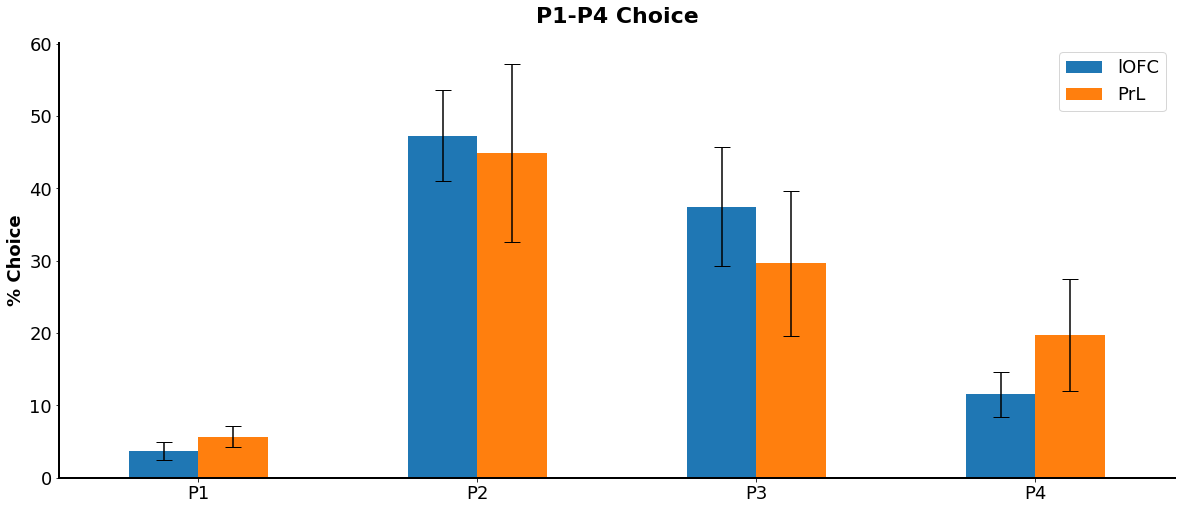

In [56]:
choice_bar_plot(startsess, endsess, group_means, sem)

In [13]:
df1,risky,optimal = get_risk_status(df1, 1, 6)

lOFC_risky = [value for value in lOFC if value in risky]
lOFC_optimal = [value for value in lOFC if value in optimal]
PrL_risky = [value for value in PrL if value in risky]
PrL_optimal = [value for value in PrL if value in optimal]

groups_risk = [lOFC_risky,PrL_risky,lOFC_optimal,PrL_optimal]
group_names_risk = {0: 'lOFC risky',1: 'PrL risky', 2:'lOFC optimal', 3: 'PrL optimal'}

group_means_risk, sem_risk = get_group_means_sem(df1,groups_risk,group_names_risk)

group_means_risk

,1P1,1P2,1P3,1P4,2P1,2P2,2P3,2P4,3P1,3P2,...,trial5,trial6,prem1,prem2,prem3,prem4,prem5,prem6,mean_risk,risk_status
lOFC risky,4.51487,12.3064,75.4393,7.73945,2.17363,24.079,68.397,5.35033,1.909,23.1742,...,62.3143,60.6,32.5406,37.4162,28.0503,28.9208,32.6225,32.7247,-57.1765,2
PrL risky,8.86883,7.74711,45.6652,37.7189,10.1927,11.5214,47.5812,30.7047,6.63845,11.4947,...,61.0167,49.5667,30.89,34.8706,23.608,32.1299,14.9515,27.3913,-62.4591,2
lOFC optimal,2.50806,67.7466,14.3856,15.3597,3.26055,66.0375,14.8636,15.8384,4.6234,63.783,...,96.7727,91.2727,22.8009,22.3196,22.406,19.0138,16.1252,17.2759,39.5642,1
PrL optimal,7.86962,79.8386,7.48185,4.80994,3.6818,84.5228,4.46777,7.32764,1.60747,87.1255,...,102,100.8,21.2851,22.3556,9.90185,17.523,11.6532,16.0876,77.6133,1


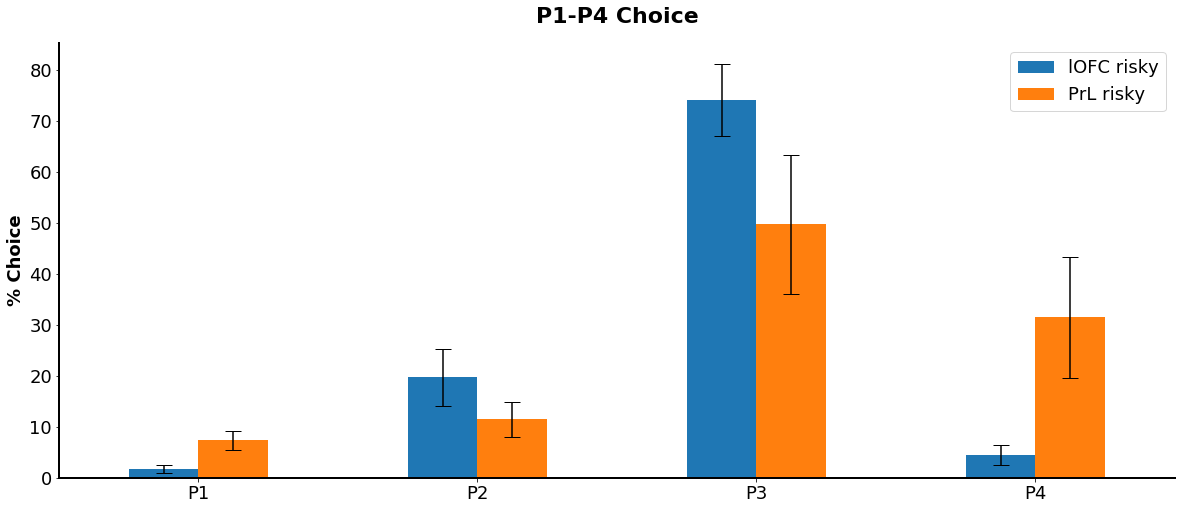

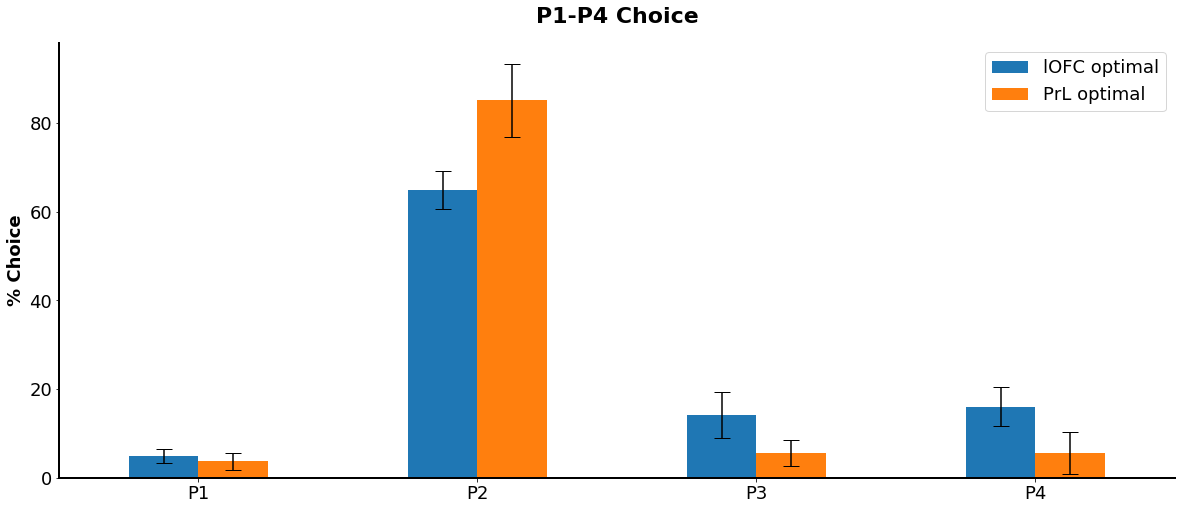

In [57]:
choice_bar_plot(startsess,endsess,group_means_risk,sem_risk, groups = ['lOFC risky', 'PrL risky'])
choice_bar_plot(startsess,endsess,group_means_risk,sem_risk,groups = ['lOFC optimal', 'PrL optimal'])

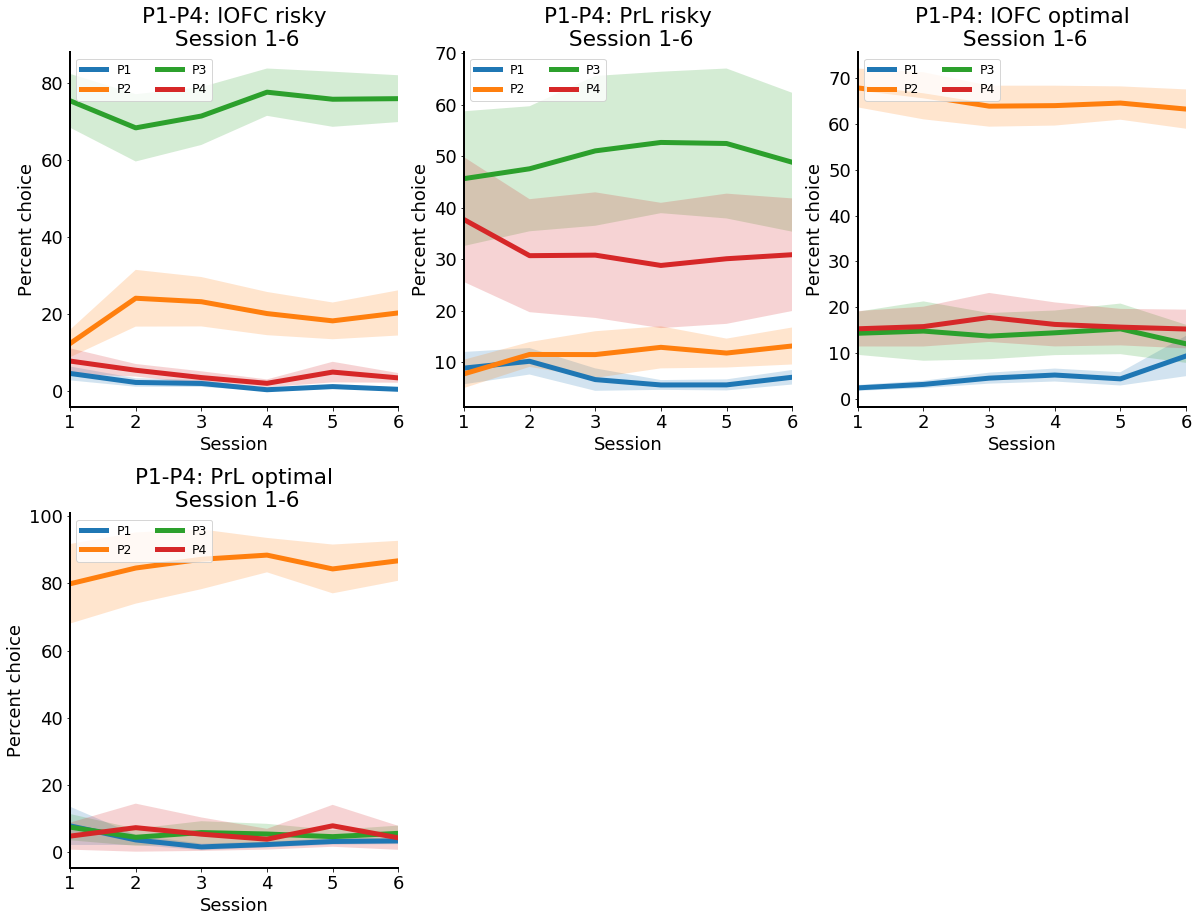

In [16]:
choice_plot(group_names_risk,startsess, endsess,group_means_risk,sem_risk, highlight = None)

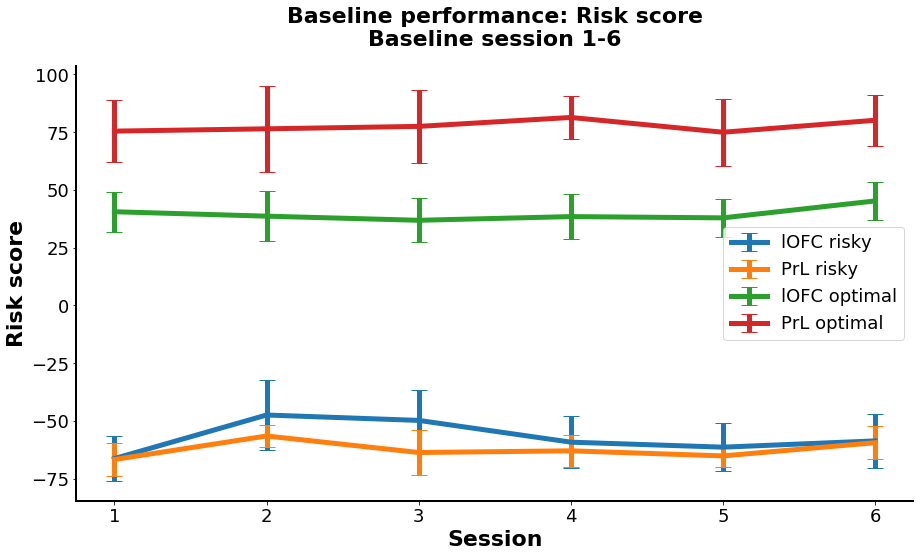

In [66]:
rgt_plot('risk',startsess,endsess,group_names_risk,group_means_risk,sem_risk, title = title, var_title = 'Risk score')

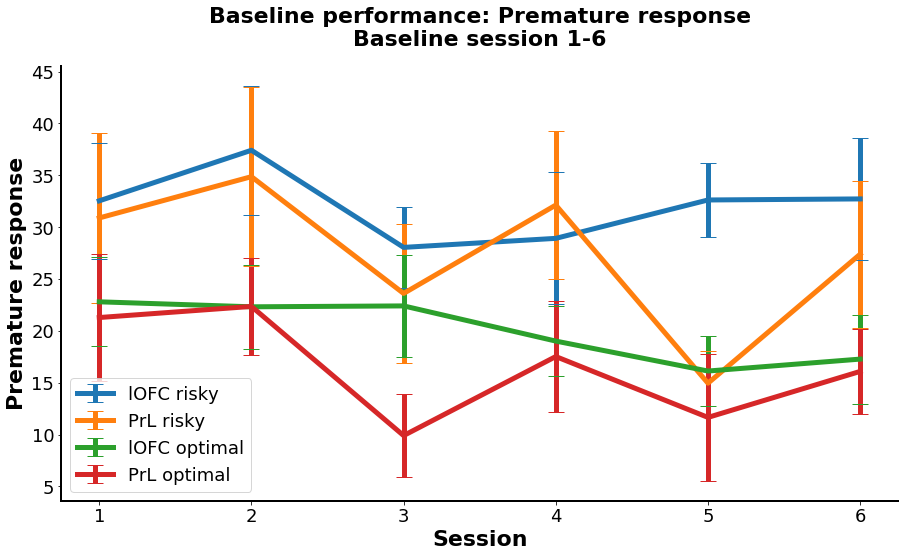

In [67]:
rgt_plot('prem',startsess,endsess,group_names_risk,group_means_risk,sem_risk, title = title, var_title = 'Premature response')

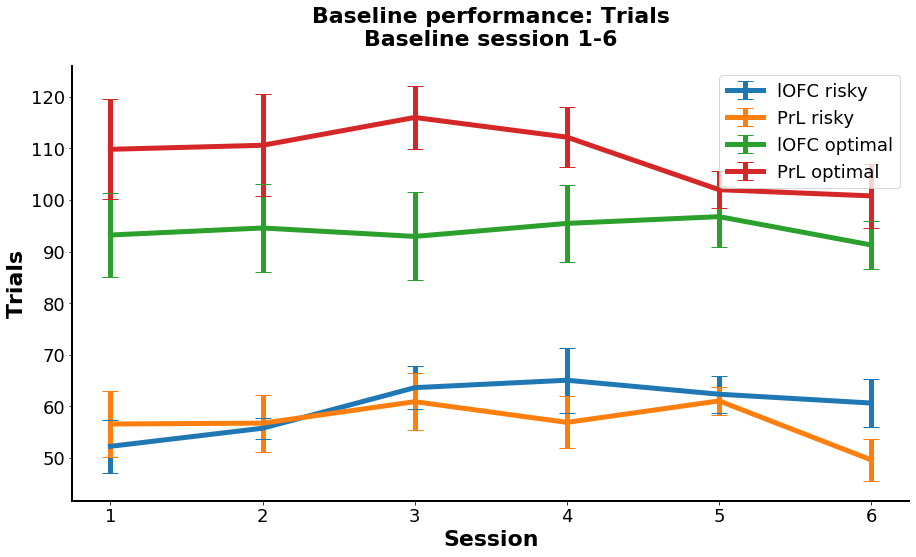

In [71]:
rgt_plot('trial',startsess,endsess,group_names_risk,group_means_risk,sem_risk, title = title, var_title = 'Trials')

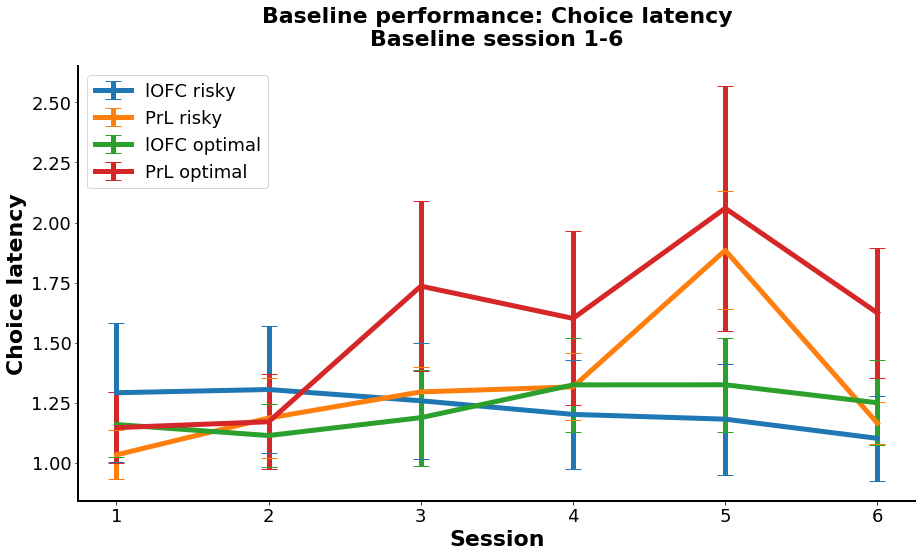

In [68]:
rgt_plot('choice_lat',startsess,endsess,group_names_risk,group_means_risk,sem_risk, title = title, var_title = 'Choice latency')

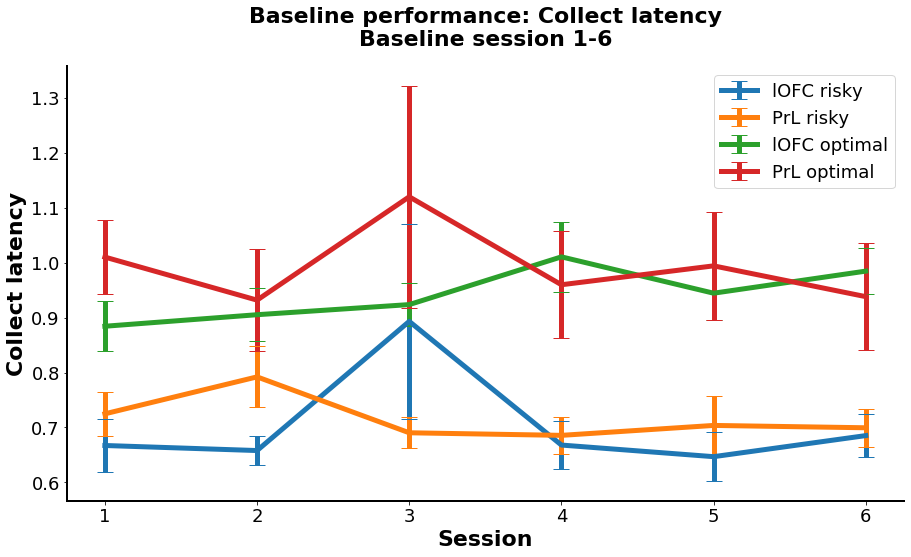

In [69]:
rgt_plot('collect_lat',startsess,endsess,group_names_risk,group_means_risk,sem_risk, title = title, var_title = 'Collect latency')

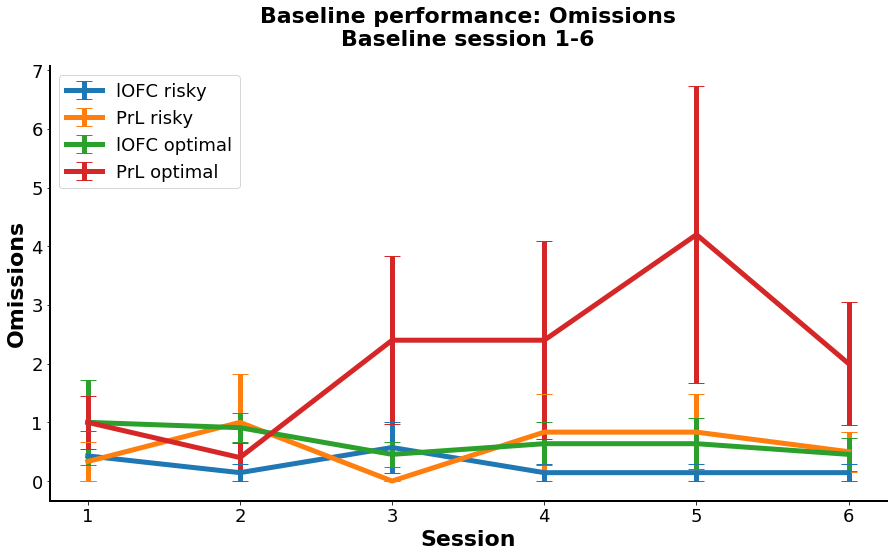

In [64]:
rgt_plot('omit',startsess,endsess,group_names_risk,group_means_risk,sem_risk,title = title, var_title = 'Omissions')

In [175]:
export_to_excel(df1,groups,'brain_region','..\\PhD_data\\BH06\\BH06_baseline.xlsx')

In [72]:
export_to_excel(df1,groups,'brain_region', '..\\PhD_data\\BH06\\BH06_baseline_asin.xlsx', asin = True)